# Study of Image classification with modern MLP Mixer model and CKA

**Author:** [Arturo Flores](https://www.linkedin.com/in/afloresalv/)<br>
**Based on (MLP-MIXER):**  https://keras.io/examples/vision/mlp_image_classification/

# Setup for the MLP-Mixer Architecture

################################################################

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt 
from scipy.stats import norm
from matplotlib.ticker import FormatStrFormatter
import datetime
import pickle
# Files imported from the sleected GitHub https://cka-similarity.github.io/
from CKA_Google import *
import seaborn as sns 
import random
import matplotlib.pyplot as plt 

D:\Program_Files\Anaconda3\envs\AI\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


# Experiment 2 : Explore the importance of different widths

## Configure the hyperparameters

In [2]:
weight_decay = 0.0001
batch_size = 512 
num_epochs = 50
dropout_rate = 0.2
learning_rate = 0.005

## Selected Architecture: B/32

image_size = 224  # We'll resize input images to this size. Square
patch_size = 32  # Size of the patches to be extracted from the input images. Square
num_patches = (image_size // patch_size) ** 2  # Size of the data array, or sequence length (S)
embedding_dim = [256,384,512,640]  
num_blocks = [12] # Fixed number of layers Dimension

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

now = datetime.datetime.today()
date = now.strftime("%Y-%m-%d")
str(date)

Image size: 224 X 224 = 50176
Patch size: 32 X 32 = 1024 
Patches per image: 49
Elements per patch (3 channels): 3072


'2022-03-15'

## Prepare the data

In [3]:
#Dataset for training 

num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#plt.imshow(x_train[1])

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Build a classification model

In [4]:
def build_classifier(blocks, embedding_dim, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data. 
    augmented = data_augmentation(inputs)
    # Create patches. 
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks. ## (sequential_82)
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor. 
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation) 
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)


## Define an experiment

In [5]:
def run_experiment(model):
    # Create Adam optimizer with weight decay. Regularization that penalizes the increase of weight - with a facto alpha - to correct the overfitting
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        #Negative Log Likelihood = Categorical Cross Entropy
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping regularization callback. 
    # It ends at a point that corresponds to a minimum of the L2-regularized objective
    #early_stopping = tf.keras.callbacks.EarlyStopping(
    #    monitor="val_loss", patience=10, restore_best_weights=True
    #)
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history, accuracy, top_5_accuracy

## Use data augmentation
Their state is not set during training; it must be set before training, either by initializing them from a precomputed constant, or by "adapting" them on data.

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement patch extraction as a layer

In [7]:

class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        #Extract the shape dimension in the position 0 = columns
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            #Without overlapping, stride horizontally and vertically
            strides=[1, self.patch_size, self.patch_size, 1],
            #Rate: Dilation factor [1 1* 1* 1] controls the spacing between the kernel points.
            rates=[1, 1, 1, 1],
            #Patches contained in the images are considered, no zero padding
            padding="VALID",
        )
        #shape[-1], number of colummns, as well as shape[0]
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config().copy()
        config.update ({
            'patch_size' : self.patch_size ,
            'num_patches' : self.num_patches
        })
        return config

## The MLP-Mixer model

The MLP-Mixer is an architecture based exclusively on
multi-layer perceptrons (MLPs), that contains two types of MLP layers:

1. One applied independently to image patches, which mixes the per-location features.
2. The other applied across patches (along channels), which mixes spatial information.

This is similar to a [depthwise separable convolution based model](https://arxiv.org/pdf/1610.02357.pdf)
such as the Xception model, but with two chained dense transforms, no max pooling, and layer normalization
instead of batch normalization.

### Implement the MLP-Mixer module

In [8]:

class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

    def get_config(self): 
        config = super(MLPMixerLayer, self).get_config().copy()
        config.update ({
            'num_patches' : num_patches,
            'embedding_dim' : embedding_dim,
            'dropout_rate' : dropout_rate,
        })
        return config

## Build, train, and evaluate the MLP-Mixer model

Note that training the model with the current settings on a V100 GPUs
takes around 8 seconds per epoch.

In [9]:
# Report: Learning Curve
def curves(history):
    ymax1 = min(history["loss"])
    xmax1 = history["loss"].index(ymax1)
    ymax2 = min(history["val_loss"])
    xmax2 = history["val_loss"].index(ymax2)
    plt.title("Cross Entropy Loss")
    plt.plot(history["loss"], color = 'blue', label = 'Training')
    plt.plot(history["val_loss"], color = 'orange', label = 'Testing')
    plt.xlabel("Epochs")
    plt.annotate('Max:' + str(round(ymax1,2)) , xy = (xmax1, ymax1), xytext = (xmax1*0.93, 1.07*ymax1), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax2,2)) , xy = (xmax2, ymax2), xytext = (xmax2*0.93, 1.07*ymax2), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.xlim([0,num_epochs])
    plt.legend()
    plt.show()
    # Graph accuracy
    ymax3 = max(history["acc"])
    xmax3 = history["acc"].index(ymax3)
    ymax4 = max(history["val_acc"])
    xmax4 = history["val_acc"].index(ymax4)
    ymax5 = max(history["top5-acc"])
    xmax5 = history["top5-acc"].index(ymax5)
    ymax6 = max(history["val_top5-acc"])
    xmax6 = history["val_top5-acc"].index(ymax6)
    plt.subplot(2,1,1)
    plt.title('Classification accuracy')
    plt.plot(history['acc'], color = 'blue', label = 'Training')
    plt.plot(history['val_acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax3,2)) , xy = (xmax3, ymax3), xytext = (xmax3*0.93, 1.2*ymax3), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax4,2)) , xy = (xmax4, ymax4), xytext = (xmax4*0.93, 0.7*ymax4), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.subplot(2,1,2)
    plt.title('Classification top5-acc')
    plt.plot(history['top5-acc'], color = 'blue', label = 'Training')
    plt.plot(history['val_top5-acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax5,2)) , xy = (xmax5, ymax5), xytext = (xmax5*0.93, 1.2*ymax5), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax6,2)) , xy = (xmax6, ymax6), xytext = (xmax6*0.87, 1.2*ymax6), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.xlim([0,num_epochs])
    plt.xlabel("Epochs")
    plt.suptitle("Learning Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Obtain activations + Visualization

In [10]:
# Preprocessing Layers + Patches + One dense layer
def Preprocessing(num_example):
    augmented = data_augmentation(x_train[num_example])
    b = Patches(patch_size, num_patches)(augmented)
    a = layers.Dense(units=embedding_dim)(b)
    inp = tf.reshape(a,[1,embedding_dim,num_patches])
    return inp

In [11]:
# Creates a random vector with indexes of a random batch selection and also regularizes the selected batch
def Batch_Preprocessing(batch_size):
    #Vector with the number of Sample of the Xtrain
    a  = list(range(0,x_train.shape[0]))
    b = random.sample(a,batch_size)
    batch_regularization = list()
    for i in range(0,batch_size):
        inter_result = Preprocessing(b[i])
        batch_regularization.append(inter_result)
    return batch_regularization


In [12]:
def visualize_out(result,layer_number,example):
    fig, (ax1, ax2)= plt.subplots(1,2)
    ax1.imshow(x_train[example])
    ax1.set_title('Original_Figure, Class: #' + str(y_train[example][0]))
    ax2.imshow(result[layer_number])
    ax2.set_title('Activations of MLP block of the Mixer #: '+ '"' + str(layer_number) + '"')
    return None

In [13]:
def Mixer_Layer_Outputs(model_input, model_output,example):
    #The input is fixed to the beginning of the mlp blocks
    intermediate_model=tf.keras.models.Model(inputs=model_input.input,outputs=model_output.output)
    #This reshape is necessary for the input of the model
    example = tf.reshape(example,[1,num_patches,embedding_dim])
    #Inference
    intermediate_prediction =intermediate_model.predict(example)
    #This reshape is standardize the output
    layactivation = intermediate_prediction.reshape((embedding_dim,num_patches))
    return layactivation

In [14]:
## Computes the outputs of each MLP-mixer Layer
def Mixer_Activations(model, example):
    total_activations = list()
    for i in range(num_blocks):
        model_input = model.layers[4].layers[0]
        model_output = model.layers[4].layers[i]
        int_total_activations = Mixer_Layer_Outputs(model_input, model_output, example)
        total_activations.append(int_total_activations)
    return  total_activations

In [15]:
#Average of layer's activation
def Prom_Mixer_Activations_Blocks(model,batch_regularization):
    sum = list()
    for i in range(0,num_blocks):
        sum_raw = np.zeros((embedding_dim,num_patches))
        sum.append(sum_raw)
    for i in range(0,batch_size):
        mixer_raw = Mixer_Activations(model,batch_regularization[i])
        for i in range(0,num_blocks):
            sum[i] = np.add(mixer_raw[i],sum[i])
    prom_mixer_activations = [ (number / batch_size)  for number in sum]
    return prom_mixer_activations

# CKA

In [16]:
# Calculates a heatmap according to the selection of a CKA_Kernel (preferred) or CKA_Linear
def Heatmap(result,type,sigma):
    dim = len(result)
    k = (dim - 1)
    heatmap_CKA = np.zeros((dim,dim))
    for i in range(0,dim):
        tr = (dim - 1)
        for j in range(0,dim):
            if type == 'kernel':
                heatmap_CKA[k][tr] = cka(gram_rbf(result[i],sigma),gram_rbf(result[j],sigma))
            elif type == 'linear':
                heatmap_CKA[k][tr] = cka(gram_linear(result[i]),gram_linear(result[j])) 
            else:
                print('There is no such category, try again')
                break

            tr -= 1
        k -= 1
    #print('CKA' + type + 'calculated')
    return heatmap_CKA

In [17]:
#Average of heatmaps (obsolet)
def Prom_Mixer_Heatmaps(batch_result,type):
    mat_heatmaps = list()
    prom_mixer_heatmap_raw = np.zeros((num_blocks,num_blocks))
    for i in range(0,batch_size):
        mixer_activations_raw = Mixer_Activations(batch_result[i])
        heatmap_raw = Heatmap(mixer_activations_raw, type)
        mat_heatmaps.append(heatmap_raw)
        prom_mixer_heatmap_raw = np.add(heatmap_raw,prom_mixer_heatmap_raw)
    prom_mixer_heatmap =  prom_mixer_heatmap_raw/batch_size  
    return prom_mixer_heatmap,mat_heatmaps

In [18]:
def visualize_Heatmap(heatmap,type,bl):
    #Number of thats that you want to appear in the plot
    tri = 4
    if type == 'kernel' or type == 'linear':
        dim = len(heatmap)
        axis_labels = list()
        for i in range(0,dim):
            axis_labels_inter = str('%i'%(i+1))
            axis_labels.append(axis_labels_inter)
        _, ax = plt.subplots(figsize=(3,3))
        ax = sns.heatmap(heatmap, xticklabels=axis_labels[::-1], yticklabels=axis_labels[::-1], ax = ax, annot=bl)
        #sns.heatmap(heatmap, xticklabels=2, yticklabels=2, ax = ax, annot=bl, cbar=True)   
        ax.invert_xaxis()
        ax.axhline(y = 0, color='k',linewidth = 4)
        ax.axhline(y = heatmap.shape[1], color = 'k', linewidth = 4)
        ax.axvline(x = 0, color ='k',linewidth = 4)
        ax.axvline(x = heatmap.shape[0], color = 'k', linewidth = 4)

        ax.set_title("CKA-"+ type)   
        ax.set_xlabel("Layer")
        ax.set_ylabel("Layer")
        plt.yticks(rotation=0)
        plt.locator_params(axis='x',nbins=tri)
        plt.locator_params(axis='y',nbins=tri)
        plt.savefig('CKA_'+ type +'.png', dpi=300)
        
    else:
        print('There is no such category, try again')

# Experiment 2 : Explore the importance of different widths

## 2A: Different widths

In [19]:
#Create different mlpmixers according to an array of widths or depths
def mlpmixer_iterations(num_patches,experiment,embedding_dim,num_blocks):
    it_widths = len(embedding_dim)
    it_blocks = len(num_blocks)
    for j in range(it_widths):
        for i in range(it_blocks):
            mlpmixer_blocks = keras.Sequential(
            [MLPMixerLayer(num_patches, embedding_dim[j], dropout_rate) for _ in range(num_blocks[i])] # creates the number of block without a 
            )
            mlpmixer_classifier = build_classifier(mlpmixer_blocks,embedding_dim[j]) # Returns the model
            history,accuracy, top_5_accuracy = run_experiment(mlpmixer_classifier)
            #Saving Results
            pwd = 'Results_Article/'+ str(experiment) +'/mlpmixer_'+ str(num_blocks[i]) + 'ly_' + str(embedding_dim[j]) + 'Dc'
            mlpmixer_classifier.save(pwd)
            np.save( pwd + '/history.npy',history.history)
            with open(pwd + '/accuracy.pkl','wb') as file:
                pickle.dump(accuracy,file)
            with open(pwd + '/top5-accuracy.pkl','wb') as file:
                pickle.dump(top_5_accuracy,file)

In [ ]:
mlpmixer_iterations(num_patches,'2A', embedding_dim,num_blocks)

Batch

In [21]:
# Heatmap of Average of layer's activation
sigma = 1
type = 'kernel'
num_blocks = 12
embedding_dimension = embedding_dim
######################################################

In [ ]:
for item in embedding_dimension:
    embedding_dim = item
    batch_prepro = Batch_Preprocessing(batch_size)
    path = 'Results_Article/2A/mlpmixer_12ly_'+ str(item) + 'Dc'
    #Call the folder
    tested_model = tf.keras.models.load_model(path)
    A1_ave_mixer_activations = Prom_Mixer_Activations_Blocks(tested_model,batch_prepro)
    A1_global_heatmap = Heatmap(A1_ave_mixer_activations,type,sigma)
    with open(path + '/heatmap_'+ type + '_Sg'+ str(sigma) +'_12ly_'+ str(item) +'Dc.pkl','wb') as file:
                pickle.dump(A1_global_heatmap,file)
    with open(path + '/activations_'+ type + '_Sg'+ str(sigma) +'_12ly_'+ str(item) +'Dc.pkl','wb') as file:
                pickle.dump(A1_ave_mixer_activations,file)

# EXPERIMENT 2: VERIFICATIONS (OPTIONAL)

## 2A

Change paths in this cell

In [30]:
#path = 'Results_Article/2A/1/mlpmixer_12ly_640Dc_2022-02-26'
path = 'Results_Article/2A/mlpmixer_12ly_256Dc'
#Call the file
#tested_history=np.load( path + '/history_2022-02-26.npy',allow_pickle='TRUE').item()
tested_history=np.load( path + '/history.npy',allow_pickle='TRUE').item()
with open(path + '/accuracy.pkl','rb') as file:
    tested_accuracy = pickle.load(file)

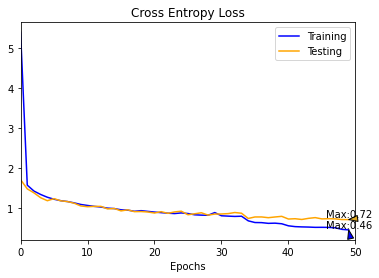

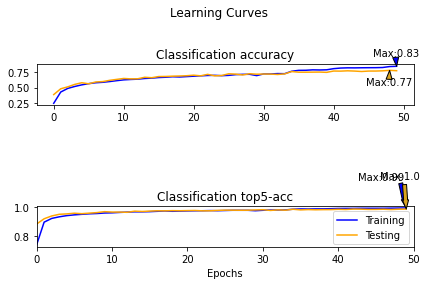

In [31]:
curves(tested_history)